# Covariance Propagation Using `Starlink-32101`

## Objectives
This example will show you how to **propagate the covariance**. We will simulate a series of **one-way**  open loop observing sessions of the ``Starlink-32101`` satellite, and we will see simulating a different number of observations affects the evolution of the **formal errors** over time. This example builds up on the [Starlink-32101 Covariance Analysis example](covariance_estimated_parameters.ipynb), so go check that out if you haven't already! 

## Import statements
Typically - in the most pythonic way - all required modules are imported at the very beginning.

Some standard modules are first loaded: `numpy` and `matplotlib.pyplot`.

Then, the different modules of `tudatpy` that will be used are imported. Most notably, the `estimation`, `estimation_setup`, and `observations` modules will be used and demonstrated within this example.

In [1]:
# Load required standard modules
import numpy as np
from matplotlib import pyplot as plt

# Load required tudatpy modules
from tudatpy import constants
from tudatpy.interface import spice
from tudatpy import dynamics
from tudatpy.dynamics import environment, environment_setup
from tudatpy.dynamics import propagation_setup, parameters_setup, simulator
from tudatpy import estimation
from tudatpy.estimation import observable_models_setup, observable_models, observations_setup, observations, estimation_analysis
from tudatpy.astro.time_representation import DateTime
from tudatpy.astro import element_conversion
from tudatpy.astro import frame_conversion

## Configuration
First, NAIF's `SPICE` kernels are loaded, to make the positions of various bodies such as the Earth, the Sun, or the Moon known to `tudatpy`. 
Subsequently, the start and end epoch of the simulation are defined, as well as the observation epochs.
As already mentioned, within this example we want to show how to propagate the covariance, while also highlighting the role that different observations have on the formal errors propagation. In particular, we will set our `simulation_start_epoch` and end `simulation_end_epoch` to be August 8, 2024 and September 5, 2024 respectively. We will then consider the three following observation scenarios:

* **Single observation session**: from August 30, 2024 to September 1, 2024, with a cadence of 60 seconds.
* **Double observation session**:
  First Session: from August 30, 2024  to September 1, 2024, with a cadence of 60 seconds.
  Second Session: from September 3, 2024,  to September 4, 2024, with a cadence of 60 seconds.
* **Single observation session**: from August 29, 2024 to `simulation_end_epoch`

Please note that, in general, the satellite might not be visible during a full osbervation session. 
For more information on J2000 and the conversion between different temporal reference frames, please refer to the [API documentation](https://py.api.tudat.space/en/latest/time_representation.html) of the `time_representation` module.

In [ ]:
# Load spice kernels
spice.load_standard_kernels()

# Set simulation start and end epochs
simulation_start_epoch = DateTime(2024, 8, 28).to_epoch()
simulation_end_epoch   = DateTime(2024, 9, 5).to_epoch()
observation_start_epoch_1 = DateTime(2024, 8, 30).to_epoch()
observation_end_epoch_1   = DateTime(2024, 9, 1).to_epoch()
observation_start_epoch_2   = DateTime(2024, 9, 3).to_epoch()
observation_end_epoch_2   = DateTime(2024, 9, 4).to_epoch()

observation_start_epoch_3   = DateTime(2024, 8, 29).to_epoch()
observation_end_epoch_3 = simulation_end_epoch

## Set up the environment
We will now create and define the settings for the environment of our simulation. In particular, this covers the creation of (celestial) bodies, vehicle(s), and environment interfaces.

### Create the main bodies
To create the systems of bodies for the simulation, one first has to define a list of strings of all bodies that are to be included. Note that the default body settings (such as atmosphere, body shape, rotation model) are taken from the `SPICE` kernel.

These settings, however, can be adjusted. Please refer to the [Available Environment Models](https://docs.tudat.space/en/latest/_src_user_guide/state_propagation/environment_setup/environment_models.html#available-model-types) in the user guide for more details.

In [3]:
# Create default body settings for "Sun", "Earth", "Moon", "Mars", and "Venus"
bodies_to_create = ["Sun", "Earth", "Moon", "Mars", "Venus"]

# Create default body settings for bodies_to_create, with "Earth"/"J2000" as the global frame origin and orientation
global_frame_origin = "Earth"
global_frame_orientation = "J2000"
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)

# Create system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

### Create the vehicle and its environment interface
We will now create the satellite - called `Starlink-32101` - for which an orbit will be simulated. Using an `empty_body` as a blank canvas for the satellite, we define mass of 260kg, a reference area (used both for aerodynamic and radiation pressure) of 20m$^2$, and a aerodynamic drag coefficient of 1.2. Idem for the radiation pressure coefficient. Finally, when setting up the radiation pressure interface, the Earth is set as a body that can occult the radiation emitted by the Sun.

In [4]:
# Create vehicle objects.
body_settings.add_empty_settings("Starlink-32101")
body_settings.get("Starlink-32101").constant_mass = 260

# Create aerodynamic coefficient interface settings
reference_area = 20  # Average projection area of a 3U CubeSat
drag_coefficient = 1.2
aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(
    reference_area, [drag_coefficient, 0.0, 0.0]
)
# Add the aerodynamic interface to the environment
body_settings.get("Starlink-32101").aerodynamic_coefficient_settings = aero_coefficient_settings

# Create radiation pressure settings
reference_area_radiation = 20  # Average projection area of a 3U CubeSat
radiation_pressure_coefficient = 1.2
occulting_bodies = dict()
occulting_bodies["Sun"] = ["Earth"]
radiation_pressure_settings = environment_setup.radiation_pressure.cannonball_radiation_target(
    reference_area_radiation, radiation_pressure_coefficient, occulting_bodies)

# Add the radiation pressure interface to the environment
body_settings.get("Starlink-32101").radiation_pressure_target_settings = radiation_pressure_settings

# Create system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

## Set up the Satellite Propagation
Having the environment created, we will define the settings for the propagation of the spacecraft. First, we have to define the body to be propagated - here, the spacecraft - and the central body - here, Earth - with respect to which the state of the propagated body is defined.

In [5]:
# Define bodies that are propagated
bodies_to_propagate = ["Starlink-32101"]

# Define central bodies of propagation
central_bodies = ["Earth"]

### Create the acceleration model
Subsequently, all accelerations (and there settings) that act on ``Starlink-32101`` have to be defined. In particular, we will consider:

* Gravitational acceleration using a spherical harmonic approximation up to 8th degree and order for Earth.
* Aerodynamic acceleration for Earth.
* Gravitational acceleration using a simple point mass model for:

    - The Sun
    - The Moon
    - Mars

* Radiation pressure experienced by the spacecraft - shape-wise approximated as a spherical cannonball - due to the Sun.

The defined acceleration settings are then applied to ``Starlink-32101`` by means of a dictionary, which is finally used as input to the propagation setup to create the acceleration models.

In [6]:
# Define the accelerations acting on `Starlink-32101`
accelerations_settings_Starlink_32101 = dict(
    Sun=[
        propagation_setup.acceleration.radiation_pressure(),
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Mars=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Moon=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Earth=[
        propagation_setup.acceleration.spherical_harmonic_gravity(8, 8),
        propagation_setup.acceleration.aerodynamic()
    ])

# Create global accelerations dictionary
acceleration_settings = {"Starlink-32101": accelerations_settings_Starlink_32101}

# Create acceleration models
acceleration_models = propagation_setup.create_acceleration_models(
    bodies,
    acceleration_settings,
    bodies_to_propagate,
    central_bodies)

### Define the initial state
Realise that the initial state of the spacecraft always has to be provided as a cartesian state - i.e. in the form of a list with the first three elements representing the initial position, and the three remaining elements representing the initial velocity.

Within this example, we will retrieve the initial state of `Starlink-32101` using its Two-Line-Elements (TLE) the date of its launch (April the 28th, 2008). The TLE strings are obtained from [www.n2yo.com](https://www.n2yo.com/satellite/?s=60447).

In [ ]:
# Retrieve the initial state of `Starlink-32101` using Two-Line-Elements (TLEs)
Starlink_tle = environment_setup.ephemeris.sgp4(
    "1 60447U 24144Y   24239.91667824 -.00652022  00000-0 -25508-2 0  9990",
    "2 60447  53.1498 303.6008 0000548  88.4809  23.6264 15.87779028  3478",
)
Starlink_ephemeris = environment_setup.create_body_ephemeris(Starlink_tle, "Starlink-32101")
initial_state = Starlink_ephemeris.cartesian_state( simulation_start_epoch )

### Create the integrator settings
For the problem at hand, we will use an RKF78 integrator with a fixed step-size of 60 seconds. This can be achieved by tweaking the implemented RKF78 integrator with variable step-size such that both the minimum and maximum step-size is equal to 60 seconds and a tolerance of 1.0

In [8]:
# Create numerical integrator settings
integrator_settings = propagation_setup.integrator.\
    runge_kutta_fixed_step_size(initial_time_step=60.0,
                                coefficient_set=propagation_setup.integrator.CoefficientSets.rkdp_87)

### Create the propagator settings
By combining all of the above-defined settings we can define the settings for the propagator to simulate the orbit of ``Starlink-32101`` around Earth. A termination condition needs to be defined so that the propagation stops as soon as the specified end epoch is reached. Finally, the translational propagator's settings are created.

In [9]:
# Create termination settings
termination_condition = propagation_setup.propagator.time_termination(simulation_end_epoch)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    initial_state,
    simulation_start_epoch,
    integrator_settings,
    termination_condition
)

## Set up the observations
Having set the underlying dynamical model of the simulated orbit, we can define the observational model. Generally, this entails the addition all required ground stations, the definition of the observation links and types, as well as the precise simulation settings.

### Add a ground station
Trivially, the simulation of observations requires the extension of the current environment by at least one observer - a ground station. For this example, we will model a single ground station located in Delft, Netherlands, at an altitude of 0m, 52.00667°N, 4.35556°E.

More information on how to use the `add_ground_station()` function can be found in the respective [API documentation](https://py.api.tudat.space/en/latest/environment_setup.html#tudatpy.dynamics.environment_setup.add_ground_station).

In [10]:
# Define the position of the ground station on Earth
station_altitude = 0.0
delft_latitude = np.deg2rad(52.00667)
delft_longitude = np.deg2rad(4.35556)

# Add the ground station to the environment
environment_setup.add_ground_station(
    bodies.get_body("Earth"),
    "TrackingStation",
    [station_altitude, delft_latitude, delft_longitude],
    element_conversion.geodetic_position_type)

### Define Observation Links and Types
To establish the links between our ground station and ``Starlink-32101``, we will make use of the [observation module](https://py.api.tudat.space/en/latest/observation.html#observation) of tudat. In particular, we choose a one-way doppler observation mode, which means that the spacecraft effectively acts as a transmitter, while the antenna is the receiver. As already done in the [Starlink-32101 Covariance Analysis example](covariance_estimated_parameters.ipynb), we will select an Earth Tracking Station located in Delft as a receiver. 

To fully define an observation model for a given link, we have to create a list of the observation model settings of all desired observable types and their associated links. This list will later be used as input to the actual estimator object.

Each observable type has its own function for creating observation model settings - in this example we will use the `one_way_doppler_instantaneous()` function to model a series of one-way open-loop (i.e. instantaneous) Doppler observations. 

In [11]:
# Define the uplink link ends for one-way observable
link_ends = dict()
link_ends[observable_models_setup.links.receiver] = observable_models_setup.links.body_reference_point_link_end_id("Earth", "TrackingStation")
link_ends[observable_models_setup.links.transmitter] = observable_models_setup.links.body_origin_link_end_id("Starlink-32101")

# Create observation settings for each link/observable
link_definition = observable_models_setup.links.LinkDefinition(link_ends)
observation_settings_list = [observable_models_setup.model_settings.one_way_doppler_instantaneous(link_definition)]

### Finally: Covariance Propagation
In order to propagate the covariance, we need to define the **observation settings**, **the parameters to estimate**. We also need to select an **input covariance**.  
The set up of the estimation process and the covariance propagation is outlined below. Note that we will iterate this procedure over the three observation scenarios, using a **for loop**. 

#### 1 - Define Observation Simulation Settings
The observation simulation settings:

1) allows for setting up of the **time intervals** at which observations are simulated (keep in mind the **three different observation scenarios** we want to simulate!);
2) allows for the definition of a noise level to simulate noisy observations
3) allows for the definition of the **viability criteria** and noise of the observation (we will set a minimum required elevation angle of **15 degrees**)

#### 2 - Define the Parameters to Estimate
For this example estimation, we decided to estimate the initial state of `Starlink-32101`, its drag coefficient, and the gravitational parameter of Earth. A comprehensive list of parameters available for estimation is provided at [this link (TudatPy API Reference)](https://py.api.tudat.space/en/latest/parameter.html).

#### 3 - Perform the observations simulation
Using the created `Estimator` object, we can perform the simulation of observations by calling its `simulate_observations()` method, see the [API reference](https://py.api.tudat.space/en/latest/estimation/observations_setup/observations_wrapper.html#tudatpy.estimation.observations_setup.observations_wrapper.simulate_observations). Note that to know about the time settings for the individual types of observations, this function makes use of the earlier defined observation simulation settings.

#### 4 - Define the Input Covariance
We collect all relevant inputs in the form of a covariance input, with the variance represented by the noise levels we chose earlier. This will be given as an input to the estimation process, to obtain `covariance_output = estimator.compute_covariance(covariance_input)`. The `covariance_output` will then become the initial covariance to be propagated by subsequent applications of the **state transition matrix**, initialized by the function `state_transition_interface` of the `estimator` object. 

#### 5 - Propagate the Covariances and the Formal Errors
Covariances and Formal Errors are propagated at the `output_times = simulation_times`, using the functions `propagate_covariance_split_output`, `propagate_formal_errors_split_output` (or `propagate_covariance`, `propagate_formal_errors`) of the estimation class, and through the above-defined state transition matrix. Please note that, in principle, one does not need to propagate the **formal errors** if the **propagated covariance** is already available. This is because the formal errors constitute the diagonal elements (**variances**) of the covariance matrix (to learn more about this, also check the [Starlink-32101 Parameter Estimation example](full_estimation_example.ipynb).)

#### 6 - Append Results
We append the formal errors and the covariance obtained for each scenario to the respective lists: `formal_errors_list`, `covariances_list`.

In [12]:
# 1 - Define Observation Simulation Settings

simulation_times = np.arange(simulation_start_epoch, simulation_end_epoch, 60.0)

observation_times_1 = np.arange(observation_start_epoch_1, observation_end_epoch_1, 60.0)
observation_times_2 = np.arange(observation_start_epoch_2, observation_end_epoch_2, 60.0)
observation_times_3 = np.arange(observation_start_epoch_3, observation_end_epoch_3, 60.0)

output_times = simulation_times
covariance_output_list = []
formal_errors_list = []
covariances_list = []

for n_scenario in [1,2,3]:
    print(f'Scenario n. {n_scenario}\n')
    print(f'Setting up Estimation and Propagating Covariance ...\n')
    if n_scenario == 1:
        observation_times = observation_times_1
    elif n_scenario == 2:
        observation_times = np.concatenate((observation_times_1, observation_times_2))
    else:
        observation_times = observation_times_3

    observation_simulation_settings = observations_setup.observations_simulation_settings.tabulated_simulation_settings(
        observable_models_setup.model_settings.one_way_instantaneous_doppler_type,
        link_definition,
        observation_times
    )

    # Add noise levels of roughly 1.0E-3 [m/s] and add this as Gaussian noise to the observation
    noise_level = 1.0E-3
    observations_setup.random_noise.add_gaussian_noise_to_observable(
        [observation_simulation_settings],
        noise_level,
        observable_models_setup.model_settings.one_way_instantaneous_doppler_type
    )

    # Create viability settings
    viability_setting = observations_setup.viability.elevation_angle_viability(["Earth", "TrackingStation"], np.deg2rad(15))
    observations_setup.viability.add_viability_check_to_all(
        [observation_simulation_settings],
        [viability_setting]
    )


# 2 - Define the Parameters to Estimate
    
    # Setup parameters settings to propagate the state transition matrix
    parameter_settings = parameters_setup.initial_states(propagator_settings, bodies)
    
    # Add estimated parameters to the sensitivity matrix that will be propagated
    parameter_settings.append(parameters_setup.gravitational_parameter("Earth"))
    parameter_settings.append(parameters_setup.constant_drag_coefficient("Starlink-32101"))
    
    # Create the parameters that will be estimated
    parameters_to_estimate = parameters_setup.create_parameter_set(parameter_settings, bodies)
    
    # Create the estimator
    estimator = estimation_analysis.Estimator(
        bodies,
        parameters_to_estimate,
        observation_settings_list,
        propagator_settings)

# 3 - Perform the observations simulation
    
    # Simulate required observations
    simulated_observations = observations_setup.observations_wrapper.simulate_observations(
        [observation_simulation_settings],
        estimator.observation_simulators,
        bodies)

# 4 - Define the Input Covariance
            
    # Define weighting of the observations in the inversion
    weights_per_observable = {observations.observations_processing.observation_parser(
        observable_models_setup.model_settings.one_way_instantaneous_doppler_type ): noise_level ** -2}
    simulated_observations.set_constant_weight_per_observation_parser( weights_per_observable )

    # Create input object for covariance analysis
    covariance_input = estimation_analysis.CovarianceAnalysisInput(
        simulated_observations)
    
    # Set methodological options
    covariance_input.define_covariance_settings(
        reintegrate_variational_equations=False)

    # Perform the covariance analysis
    covariance_output = estimator.compute_covariance(covariance_input)
    covariance_output_list.append(covariance_output)

    initial_covariance = covariance_output.covariance
    state_transition_interface = estimator.state_transition_interface

# 5 - Propagate the Covariances and the Formal Errors
    
    #Propagate the covariancees and the formal errors
    propagated_covariances = estimation_analysis.propagate_covariance_split_output(initial_covariance,state_transition_interface,output_times)
    # Propagate formal errors over the course of the orbit
    propagated_formal_errors = estimation_analysis.propagate_formal_errors_split_output(
        initial_covariance=initial_covariance,
        state_transition_interface=state_transition_interface,
        output_times=output_times)
    # Split tuple into epochs and formal errors
    epochs = np.array(propagated_formal_errors[0])
    formal_errors = np.array(propagated_formal_errors[1])
    formal_errors_list.append(formal_errors)

# 6 - Append Results
    
    covariances = np.array(propagated_covariances[1])
    covariances_list.append(covariances)
    print('... Done.\n')

print('All Done.\n')
    

Scenario n. 1

Setting up Estimation and Propagating Covariance ...

Calculating residuals and partials 27
... Done.

Scenario n. 2

Setting up Estimation and Propagating Covariance ...



Warning, function setConstantPerObservableWeightsMatrix is deprecated, weights should preferably be defined at the observation collection level.Warning, function setConstantPerObservableWeightsMatrix is deprecated, weights should preferably be defined at the observation collection level.

Calculating residuals and partials 37
... Done.

Scenario n. 3

Setting up Estimation and Propagating Covariance ...

Calculating residuals and partials 89
... Done.

All Done.



Warning, function setConstantPerObservableWeightsMatrix is deprecated, weights should preferably be defined at the observation collection level.

## Results post-processing: Correlations and Formal Errors Time Evolution

### Cartesian Coordinates
Let's visualize the obtained propagated **cartesian** formal errors for each selected observation scenario. 

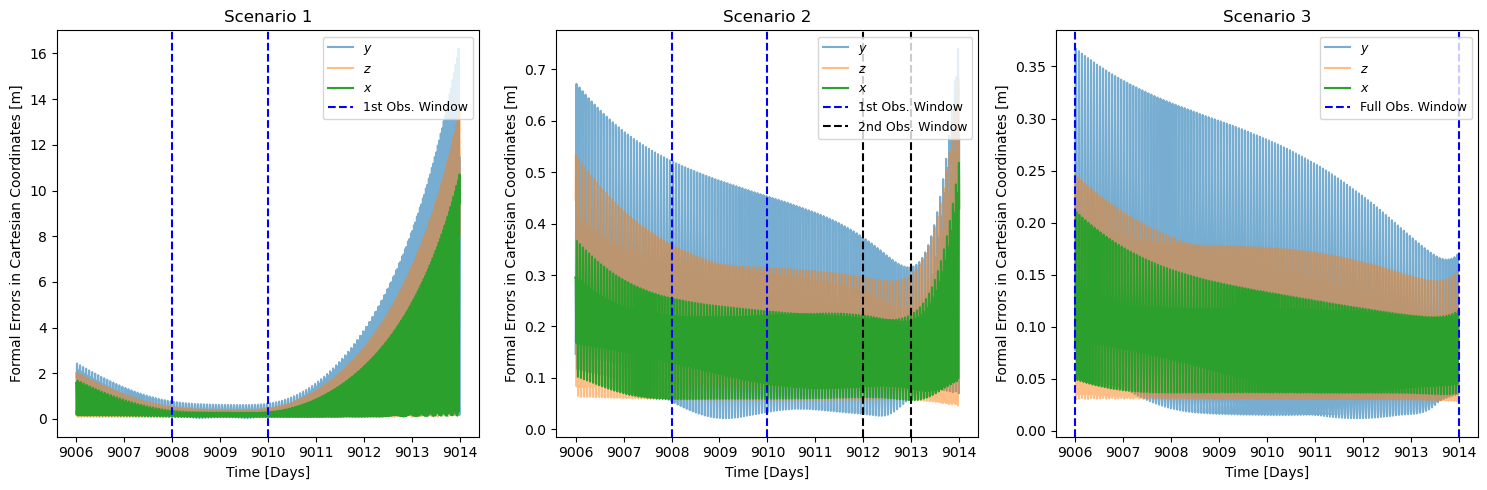

In [13]:
fig2, axs2 = plt.subplots(1, 3, figsize=(15, 5))
times_plot = output_times / (24*3600)

# Create the heatmaps and add colorbars
axs2[0].plot(times_plot, formal_errors_list[0][:, 1], label=r"$y$", alpha = 0.6)
axs2[0].plot(times_plot, formal_errors_list[0][:, 2], label=r"$z$", alpha = 0.5)
axs2[0].plot(times_plot, formal_errors_list[0][:, 0], label=r"$x$", alpha = 1)
axs2[0].axvline(observation_start_epoch_1/(24*3600), color = 'b', label = '1st Obs. Window', linestyle = '--')
axs2[0].axvline(observation_end_epoch_1/(24*3600), color = 'b', linestyle = '--')
axs2[0].set_title('Scenario 1')

axs2[1].plot(times_plot, formal_errors_list[1][:, 1], label=r"$y$", alpha = 0.6)
axs2[1].plot(times_plot, formal_errors_list[1][:, 2], label=r"$z$", alpha = 0.5)
axs2[1].plot(times_plot, formal_errors_list[1][:, 0], label=r"$x$", alpha = 1)


# Plot observation vertical lines
axs2[1].axvline(observation_start_epoch_1/(24*3600), color = 'b', label = '1st Obs. Window', linestyle = '--')
axs2[1].axvline(observation_end_epoch_1/(24*3600), color = 'b', linestyle = '--')
axs2[1].axvline(observation_start_epoch_2/(24*3600), color = 'k', label = '2nd Obs. Window', linestyle = '--')
axs2[1].axvline(observation_end_epoch_2/(24*3600), color = 'k', linestyle = '--')
axs2[1].set_title('Scenario 2')

axs2[2].plot(times_plot, formal_errors_list[2][:, 1], label=r"$y$", alpha = 0.6)
axs2[2].plot(times_plot, formal_errors_list[2][:, 2], label=r"$z$", alpha = 0.5)
axs2[2].plot(times_plot, formal_errors_list[2][:, 0], label=r"$x$",alpha = 1 )
axs2[2].axvline(simulation_start_epoch/(24*3600), color = 'b', label = 'Full Obs. Window', linestyle = '--')
axs2[2].axvline(simulation_end_epoch/(24*3600), color = 'b', linestyle = '--')
axs2[2].set_title('Scenario 3')

for ax in axs2.flat:
    ax.set(xlabel='Time [Days]', ylabel='Formal Errors in Cartesian Coordinates [m]')
    ax.legend(loc = 'upper right', fontsize = 9)
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs2.flat:
    ax.set_aspect('auto')

plt.tight_layout()
plt.show()

### RSW Coordinates
Making use of the cool Tudat `frame_conversion` class, we are also able to express these results in the **RSW** coordinates.
In order to do this, we need to retrieve the estimated cartesian states for `Starlink-32101` and rotate these into a the RSW reference frame, for each time. The retrieved (instantaneous) rotation matrix is then used to retrieve the covariance matrix in the new reference system. As above, this is done for each observation scenario. 

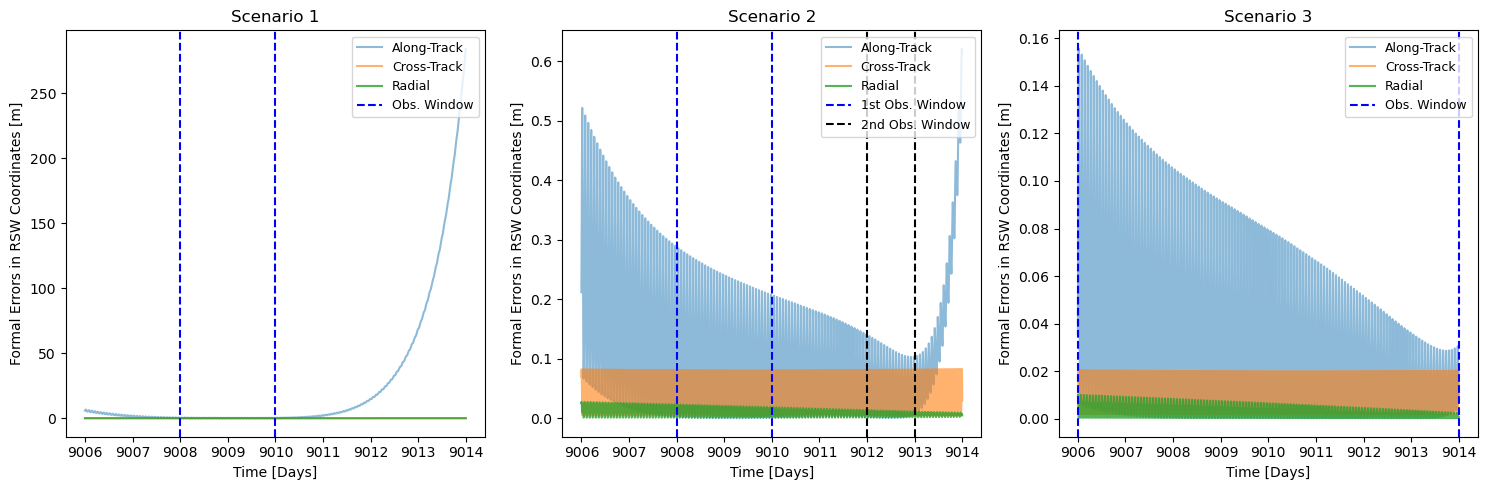

In [14]:
estimation_states = []
rot_matrix_list = []


# Assuming estimation_states, rot_matrix_list, output_times, and converted_formal_errors_matrix_list are defined as provided

# Initialize the converted formal errors matrix list
converted_formal_errors_matrix_list = np.zeros([3, len(output_times), 6, 6])

# Iterate through the scenarios and time steps
for j in [0, 1, 2]:
    for i, time in enumerate(output_times):
        state_est = bodies.get('Starlink-32101').ephemeris.cartesian_state(time)
        rot_matrix = frame_conversion.inertial_to_rsw_rotation_matrix(state_est)
        full_rot_matrix = np.block([[rot_matrix, np.zeros([3,3])], [np.zeros([3,3]), rot_matrix]])
        cov = np.matrix(covariances_list[j][i])
        converted_formal_errors_matrix = full_rot_matrix @ cov @ full_rot_matrix.T
        converted_formal_errors_matrix_list[j, i] = converted_formal_errors_matrix
        
# Plotting the (0, 0) element for each scenario
fig3, axs3 = plt.subplots(1, 3, figsize=(15, 5))

for j in range(3):
    axs3[j].plot(times_plot, np.abs(converted_formal_errors_matrix_list[j, :, 1, 1]), label=f"Along-Track", alpha=0.5)
    axs3[j].plot(times_plot, np.abs(converted_formal_errors_matrix_list[j, :, 2, 2]), label=f"Cross-Track", alpha=0.6)
    axs3[j].plot(times_plot, np.abs(converted_formal_errors_matrix_list[j, :, 0, 0]), label=f"Radial", alpha=0.8)
    axs3[j].set_xlabel('Time (years)')
    axs3[j].set_ylabel('Formal Errors in RSW')
    axs3[j].legend()

# Plot observation vertical lines
axs3[0].axvline(observation_start_epoch_1/(24*3600), color = 'b', label = 'Obs. Window', linestyle = '--')
axs3[0].axvline(observation_end_epoch_1/(24*3600), color = 'b', linestyle = '--')
axs3[0].set_title('Scenario 1')

axs3[1].axvline(observation_start_epoch_1/(24*3600), color = 'b', label = '1st Obs. Window', linestyle = '--')
axs3[1].axvline(observation_end_epoch_1/(24*3600), color = 'b', linestyle = '--')
axs3[1].axvline(observation_start_epoch_2/(24*3600), color = 'k', label = '2nd Obs. Window', linestyle = '--')
axs3[1].axvline(observation_end_epoch_2/(24*3600), color = 'k', linestyle = '--')
axs3[1].set_title('Scenario 2')

axs3[2].axvline(simulation_start_epoch/(24*3600), color = 'b', label = 'Obs. Window', linestyle = '--')
axs3[2].axvline(simulation_end_epoch/(24*3600), color = 'b', linestyle = '--')
axs3[2].set_title('Scenario 3')


for ax in axs3.flat:
    ax.set(xlabel='Time [Days]', ylabel='Formal Errors in RSW Coordinates [m]')
    ax.legend(loc = 'upper right', fontsize = 9)
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs3.flat:
    ax.set_aspect('auto')
    
plt.tight_layout()
plt.show()